# Introduction

This notebook serves as an inferential statistic analysis of the projecet on crimes dataset. The original raw data is available from http://www.houstontx.gov/police/cs/index-2.htm. A detailed introduction on the data cleaning process can be found in [previous report](https://github.com/phyhouhou/SpringboardProjects/blob/master/FirstCapstoneProject/data_cleaning_capstone_project.ipynb).



In [21]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set_context('paper',font_scale=2)#'paper',#font_scale=2 set fontsize doulble the size of default
#sns.set_style('white')



# Load data
Raw data can be downloaded in the [HPD website](http://www.houstontx.gov/police/cs/index-2.htm). I've downloaded the data and made it clean. Read the data cleaning [report](https://github.com/phyhouhou/SpringboardProjects/blob/master/FirstCapstoneProject/data_cleaning_capstone_project.ipynb) for details. The cleaned data is also uploaded [online](https://file.io/eLoGQ3).

In [2]:
import pandas as pd
crimes=pd.read_csv('crimes_clean.csv', parse_dates=['Date'],index_col='Date')
crimes.head()

,Hour,OffenseType,Beat,Premise,BlockRange,StreetName,Type,Suffix,OffenseNum
Date,,,,,,,,,
2010-01-01,2,Theft,7C20,13,3100-3199,COLLINGSWORTH,-,-,1
2010-01-01,2,Robbery,20G70,18,1900-1999,WESTMEAD,DR,-,1
2010-01-01,9,Robbery,4F30,13,1700-1799,BRITTMOORE,RD,-,1
2010-01-01,10,Robbery,20G10,18,2900-2999,WEST SAM HOUSTON,PKWY,S,1
2010-01-01,14,Robbery,20G80,8,1000-1099,WEST OAKS MALL,-,-,1


In [3]:
date_crime=crimes.groupby(['Date','OffenseType']).size().unstack()#.fillna(0)
c=date_crime.fillna(0).copy()
c.head()

OffenseType,AggravatedAssault,AutoTheft,Burglary,Murder,Rape,Robbery,Theft
Date,,,,,,,
2010-01-01,53.0,21.0,77.0,1.0,13.0,31.0,215.0
2010-01-02,15.0,28.0,67.0,0.0,2.0,32.0,200.0
2010-01-03,29.0,34.0,52.0,0.0,0.0,38.0,179.0
2010-01-04,25.0,29.0,94.0,0.0,1.0,24.0,211.0
2010-01-05,21.0,20.0,88.0,2.0,3.0,19.0,183.0


# Weekday Crimes v.s. Weekend Crimes

According to the [EDA](https://github.com/phyhouhou/SpringboardProjects/blob/master/FirstCapstoneProject/Exploratory_Data_Analysis_Capstone_Project.ipynb), dominant property crimes like 'Theft', 'Burglary' are more frequent during weekdays than weekends while violent crimes like 'AggravatedAssault', 'Robbery', 'Rape', 'Murder' are more likely to occur during weekends than weekdays. A follow-up question is which has a higher crime rate on average, weekday or weekend? The EDA shows that weekday tends to have higher crime rate than weekend days. Is it statistically true?

In [7]:
import calendar
weekday=list(calendar.day_name)#day_abbr#day_name

index_weekday = date_crime.index.weekday_name
crimes_by_weekday =date_crime.groupby(index_weekday).mean().reindex(weekday)#.sum(axis=1)

weekend=crimes_by_weekday.loc['Saturday':'Sunday'].mean(axis=0).round(0)
weekday=crimes_by_weekday.loc['Monday':'Friday'].mean(axis=0).round(0)
week_day_end=pd.concat([weekday,weekend],axis=1)
week_day_end.columns=['Weekday','Weekend']
week_day_end

,Weekday,Weekend
OffenseType,,
AggravatedAssault,26.0,34.0
AutoTheft,34.0,35.0
Burglary,68.0,48.0
Murder,1.0,1.0
Rape,3.0,3.0
Robbery,25.0,28.0
Theft,194.0,174.0


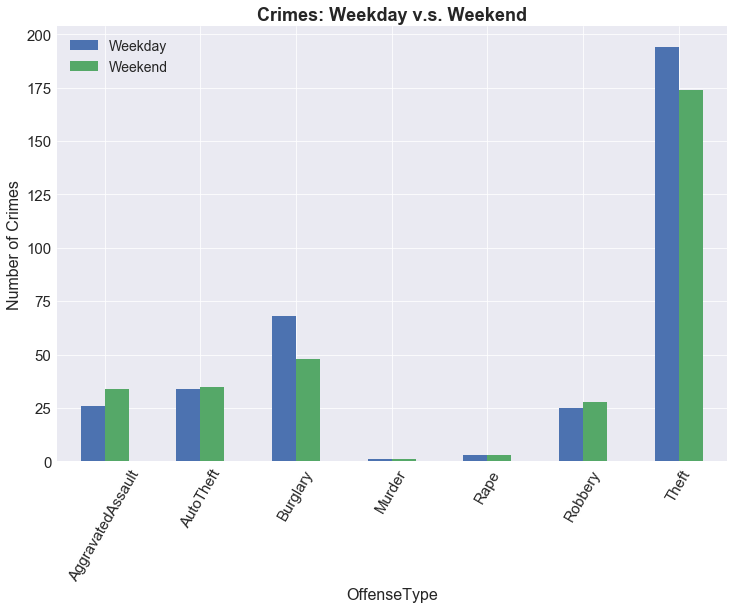

In [22]:
week_day_end.plot(kind='bar',rot=60,figsize=(12,8),fontsize=15)
plt.ylabel('Number of Crimes',fontsize=16)
plt.xlabel('OffenseType',fontsize=16)
plt.legend(fontsize=14)
plt.title('Crimes: Weekday v.s. Weekend',fontweight='bold',fontsize=18);

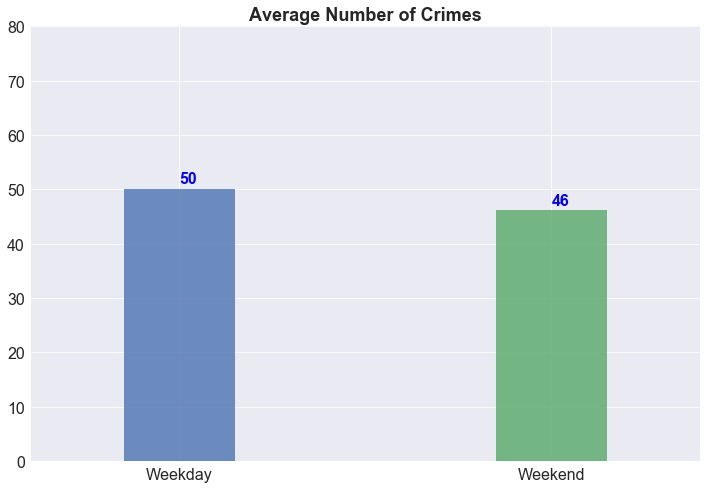

In [23]:
avg=week_day_end.mean(axis=0)
ax=avg.plot('bar',rot=0,figsize=(12,8),ylim=(0,80),width=0.3,fontsize=16,alpha=0.8)
plt.title('Average Number of Crimes',fontweight='bold',fontsize=18)

for i, v in enumerate(avg):
    ax.text( i,v + 1, int(round(v,0)), color='blue', fontweight='bold',fontsize=16)


#  Hypothesis test
Is the average number of crime on weekday significantly greater than that of weekend day? We will compute the probability of getting at least a difference of 4 in the average count under the hypothesis that the distributions of weekday and weekend day crimes are identical. 

## Reshape the data
Take daily averge of crimes and group that into either week day average crime (if the day is from 'Monday' to 'Friday') or week end day averge crime (for 'Saturday' and 'Sunday').

In [10]:
c['Day']=c.index.weekday_name
c['Crime_daily']=c.mean(axis=1)

In [11]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
wdict={i:'weekend' if i in ['Saturday','Sunday'] else 'weekday' for i in days}

#Select dates starting from the first week of Janualy 2010, so that we can 
#calculate the averge number of crimes for weekday and weekend day conviently.
cc=c.loc['2010-01-04':,['Day','Crime_daily']]
cc.Day=cc.Day.replace(wdict)
cc.head(7)


OffenseType,Day,Crime_daily
Date,,
2010-01-04,weekday,54.857143
2010-01-05,weekday,48.000000
2010-01-06,weekday,55.428571
2010-01-07,weekday,53.857143
2010-01-08,weekday,51.428571
2010-01-09,weekend,50.285714
2010-01-10,weekend,45.428571


In [12]:
# Define a function to calcuate averages of every n rows
def ave_n(df,l,n):
    return df.groupby(np.arange(l)//n).mean()

In [15]:
weekday=cc.Day=='weekday'

#Take averge of every 5 oberations as the mean of that week day
wkday=ave_n(cc[weekday],np.sum(weekday),5).round(0)

#Take averge of every 2 oberations as the mean of that weekend
wkend=ave_n(cc[~weekday],np.sum(~weekday),2).round(0)

In [16]:
wkday_wkend=pd.concat([wkday,wkend],axis=1)
wkday_wkend.columns=['wkday','wkend']
wkday_wkend.head()

,wkday,wkend
0,53.0,48.0
1,54.0,52.0
2,53.0,48.0
3,51.0,40.0
4,49.0,48.0


In [17]:
wkday_wkend.info()
wkday_wkend.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 416
Data columns (total 2 columns):
wkday    417 non-null float64
wkend    417 non-null float64
dtypes: float64(2)
memory usage: 9.8 KB


,wkday,wkend
count,417.000000,417.000000
mean,49.976019,46.052758
std,4.240306,4.952864
min,14.000000,3.000000
25%,48.000000,44.000000
50%,50.000000,46.000000
75%,53.000000,49.000000
max,62.000000,57.000000


The summary statistics shows that week day crime rate is higher in average than that of weekend day.

## Normality check

goodness fit: 0.95


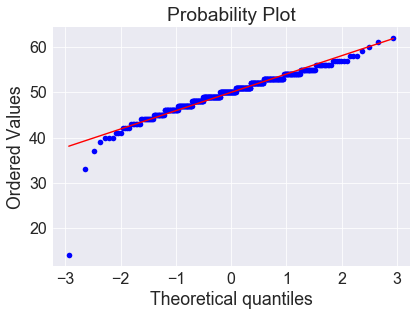

In [24]:
from scipy import stats
_,fit=stats.probplot(wkday_wkend.wkday,dist=stats.norm,plot=plt)
print('goodness fit:', '%.2f' %fit[2])


goodness fit: 0.94


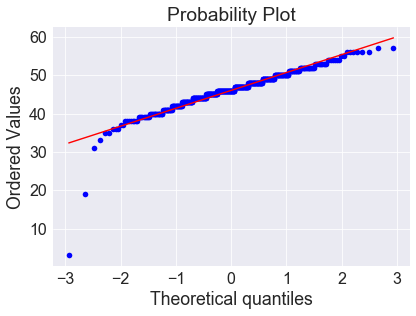

In [25]:
_,fit=stats.probplot(wkday_wkend.wkend,dist=stats.norm,plot=plt)
print('goodness fit:', '%.2f' %fit[2])

In [26]:
print('weekday p value: ',stats.normaltest(wkday_wkend.wkday)[1])
print('weekend p value: ',stats.normaltest(wkday_wkend.wkend)[1])

weekday p value:  8.712439211436335e-45
weekend p value:  5.549145755553319e-52


In [27]:
print('weekday p value: ',stats.shapiro(wkday_wkend.wkday)[1])
print('weekend p value: ',stats.shapiro(wkday_wkend.wkend)[1])

weekday p value:  3.933432542218207e-15
weekend p value:  6.104513511302539e-17


The normality check rejects the distribution of average weekday or average weekend crime is normally distributed.

## Bootstrap hypothesis test
Is the average number of crime on weekday significantly greater than that of weekend day? We will compute the probability of getting at least a difference of 4 in the average count under the hypothesis that the distributions of weekday and weekend day crimes are identical. We use a permutation test with a test statistic of the difference of means to test this hypothesis. 

In [28]:
diff=wkday_wkend.wkday.mean()-wkday_wkend.wkend.mean()

bs_permutations_replicates = np.empty(10000)
for i in range(10000):
    permuted = np.random.permutation(np.concatenate((wkday_wkend.wkday,wkday_wkend.wkend)))
    wkd_permuted =permuted[:len(wkday_wkend.wkday)]
    wke_permuted =permuted[len(wkday_wkend.wkend):]
    bs_permutations_replicates[i] = np.abs(np.mean(wkd_permuted) - np.mean(wke_permuted))
    
bs_permutations_replicates_pval = np.sum(bs_permutations_replicates >= abs(diff))/10000
print('p value :',bs_permutations_replicates_pval)

p value : 0.0


Since the p value is much less than 0.05, we reject the hypothesis that weekday has the same averge crime rate as that of weekend. 

## t-test

Since the sample size is 417 much larger than 30, we perform a two-sample t-test. It turns out that pvalue is much smaller than 0.05, indicating that the average crime rate on weekday is significantly different from that of weekend.

In [29]:
t,p=stats.ttest_ind(wkday, wkend, equal_var = False)
print('t score:', t[0])

print('p value:', p[0])



t score: 12.287522397773321
p value: 5.956274641711443e-32


## z-test
In the case of large sample size (>30), t-test and z-test are equivalent.

In [30]:
z = (diff) / np.sqrt(((wkday_wkend.wkday.std() ** 2)/ 417) + ((wkday_wkend.wkend.std() ** 2)/ 417))
print('z score:', z)

p=stats.norm.sf(abs(z)) * 2
print('p value:', p)


z score: 12.287522397773317
p value: 1.0569603086893555e-34
